**음수 청구 금액 데이터 제거 및 고객 ID 기반 정제 과정**

In [1]:
import pandas as pd

# 1️⃣ 데이터 불러오기
df = pd.read_csv('/content/sample_data/default_of_credit_card_clients - Data.csv')

# 2️⃣ 청구 금액 컬럼
bill_cols = ['BILL_AMT1','BILL_AMT2','BILL_AMT3',
             'BILL_AMT4','BILL_AMT5','BILL_AMT6']

# 3️⃣ 음수 청구 금액이 있는 고객 ID 추출
neg_customers = df[df[bill_cols].lt(0).any(axis=1)]['ID'].unique()

# 4️⃣ 해당 고객 ID 전체 제거
df_clean = df[~df['ID'].isin(neg_customers)]

# 5️⃣ 저장
df_clean.to_csv('/content/clean_removed_negative_customers.csv', index=False)

print("음수 청구금액 가진 고객 ID 제거 완료!")
print(f"제거된 고객 수: {len(neg_customers)}명")

음수 청구금액 가진 고객 ID 제거 완료!
제거된 고객 수: 1930명


**범주형 변수 정리 및 상환 상태 표준화 기반 최종 데이터셋 생성 코드**

* 교육 수준 전처리

‘4 이상(기타/불명)’으로 분류된 고객들은 수가 적지만 신용 불이행률에서 의미 있는 패턴을 보인다.
따라서 해당 구간은 삭제하지 않고 단일 범주(4번 그룹) 로 묶어 유지한다.

반면 교육 수준이 ‘0(미기재/알 수 없음)’으로 표기된 고객들은
해석 가능성도 낮고 신용 불이행률에서도 패턴을 보이지 않는다.
즉, 분석적 가치가 부족하므로 해당 데이터는 제거한다.

* 성별 전처리

성별 변수는 1(남)과 2(여)로 구분되어 있지만,
머신러닝 모델에서 처리하기 쉽도록 0과 1의 이진 변수(binary variable) 로 변환한다.
이는 성능 효율성과 해석 편의성을 높이기 위한 과정이다.

* 상환 상태(PAY) 전처리

상환 상태 변수(PAY_0~PAY_6)에는 -2와 -1이 유사 의미(정상 또는 연체 없음) 로 입력되어 있다.

너무 세분화된 값은 모델 해석을 어렵게 하고 데이터 품질을 낮출 수 있으므로,
-2 값을 -1로 통합해 범주를 정리한다.



In [2]:
import pandas as pd

# 1️⃣ 파일 불러오기
df = pd.read_csv('/content/clean_removed_negative_customers.csv')

print(f"🔍 처리 전 데이터 크기: {df.shape}")

# 2️⃣ 성별(SEX): 1=남 → 0 , 2=여 → 1
df['SEX'] = df['SEX'].replace({1: 0, 2: 1})

# 3️⃣ 교육(EDUCATION) 변환
# 3-1: 4 이상은 모두 4로 통합
df['EDUCATION'] = df['EDUCATION'].apply(lambda x: 4 if x >= 4 else x)

# 3-2: 교육수준이 0인 고객 제거
df = df[df['EDUCATION'] != 0]

# 4️⃣ 상환 상태(PAY_0~PAY_6): -2 → -1 변환
pay_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
df[pay_cols] = df[pay_cols].replace(-2, -1)

# 5️⃣ 최종 저장
df.to_csv('/content/final_credit_dataset.csv', index=False)

print("✨ 모든 전처리 완료! → final_credit_dataset.csv 저장됨")
print(f"📌 처리 후 데이터 크기: {df.shape}")



🔍 처리 전 데이터 크기: (28070, 25)
✨ 모든 전처리 완료! → final_credit_dataset.csv 저장됨
📌 처리 후 데이터 크기: (28056, 25)


**청구액 이상치 데이터 제거후     재확인**



In [3]:
import pandas as pd

# 1️⃣ 데이터 불러오기
df = pd.read_csv('/content/final_credit_dataset.csv')

# 2️⃣ 청구 금액 컬럼
bill_cols = ['BILL_AMT1','BILL_AMT2','BILL_AMT3',
             'BILL_AMT4','BILL_AMT5','BILL_AMT6']

# 3️⃣ 음수 청구 금액이 있는 고객 ID 추출
neg_customers = df[df[bill_cols].lt(0).any(axis=1)]['ID'].unique()

# 4️⃣ 해당 고객 ID 전체 제거
df_clean = df[~df['ID'].isin(neg_customers)]

# 5️⃣ 저장
df_clean.to_csv('/content/clean_removed_negative_customers.csv', index=False)

print("음수 청구금액 가진 고객 ID 제거 완료!")
print(f"제거된 고객 수: {len(neg_customers)}명")


음수 청구금액 가진 고객 ID 제거 완료!
제거된 고객 수: 0명


**결혼 여부 전처리**
- '기타'에 해당하는 고객들의 신용 불이행률이 '기혼'이나 '미혼' 카테고리에 해당하는 고객들보다 높은 신용 불이행률을 가진다. 이는 '기타' 카테고리가 매유 유의미한 해석 결과를 가져올 수 있기 때문에 삭제하지 않고 그대로 둔다. 그러나 '0'에 해당하는 '알 수 없음'의 카테고리에 해당하는 고객들은 매우 낮은 신용 불이행률을 가지기 때문에 무의미하다. 따라서 '0'카테고리는 삭제한다.

In [4]:
import pandas as pd

# 1. 데이터 불러오기 (예시)
df = pd.read_csv('/content/sample_data/final_credit_clean.csv')

print(f"--- 원본 데이터 ---")
print(f"처리 전 데이터 행 수: {len(df)}")
print(f"원본 MARRIAGE 고유값: {sorted(df['MARRIAGE'].unique())}")
print("-" * 30)


# 2. MARRIAGE (결혼 여부) 전처리
# (데이터가 54건으로 매우 적고 노이즈가 될 수 있는 0 그룹 삭제)
print("\n--- MARRIAGE 전처리 (0 그룹 삭제) ---")

# 0인 그룹의 개수를 셉니다.
count_to_remove = len(df[df['MARRIAGE'] == 0])
print(f"(참고: MARRIAGE '0' 그룹 {count_to_remove}건 삭제 예정)")

# 0이 아닌 행만 남깁니다.
df = df[df['MARRIAGE'] != 0]

print(f"처리 후 데이터 행 수: {len(df)}")
print(f"처리 후 MARRIAGE 고유값: {sorted(df['MARRIAGE'].unique())}")
print("-" * 30)

--- 원본 데이터 ---
처리 전 데이터 행 수: 28056
원본 MARRIAGE 고유값: [np.int64(0), np.int64(1)]
------------------------------

--- MARRIAGE 전처리 (0 그룹 삭제) ---
(참고: MARRIAGE '0' 그룹 15287건 삭제 예정)
처리 후 데이터 행 수: 12769
처리 후 MARRIAGE 고유값: [np.int64(1)]
------------------------------


In [5]:
import pandas as pd

# 1. 원본 파일 불러오기
# (이 스크립트와 'final_credit_clean.csv' 파일이 같은 폴더에 있어야 합니다)
try:
    df = pd.read_csv('/content/sample_data/marriage_preprocessed_data.csv')
    print(f"--- 원본 데이터 ---")
    print(f"처리 전 데이터 행 수: {len(df)}")
    print(f"원본 MARRIAGE 고유값: {sorted(df['MARRIAGE'].unique())}")
    print("-" * 30)

    # 2. MARRIAGE (결혼 여부) 전처리
    # 0인 그룹의 개수를 셉니다.
    count_to_remove = len(df[df['MARRIAGE'] == 0])
    print(f"\n--- MARRIAGE 전처리 (0 그룹 삭제) ---")
    print(f"(MARRIAGE '0' 그룹 {count_to_remove}건 삭제 예정)")

    # 0이 아닌 행만 남깁니다.
    df_processed = df[df['MARRIAGE'] != 0].copy()

    print(f"처리 후 데이터 행 수: {len(df_processed)}")
    print(f"처리 후 MARRIAGE 고유값: {sorted(df_processed['MARRIAGE'].unique())}")
    print("-" * 30)

    # 3. 새로운 CSV 파일로 저장
    new_filename = 'marriage_preprocessed_data.csv'

    # index=False: 불필요한 인덱스 열이 저장되지 않도록 합니다.
    # encoding='utf-8-sig': Excel에서 한글이 깨지지 않게 엽니다.
    df_processed.to_csv(new_filename, index=False, encoding='utf-8-sig')

    print(f"\n✅ 완료: '{new_filename}' 파일이 성공적으로 저장되었습니다.")

except FileNotFoundError:
    print(f"오류: 'final_credit_clean.csv' 파일을 찾을 수 없습니다.")
except Exception as e:
    print(f"오류 발생: {e}")

--- 원본 데이터 ---
처리 전 데이터 행 수: 12769
원본 MARRIAGE 고유값: [np.int64(1)]
------------------------------

--- MARRIAGE 전처리 (0 그룹 삭제) ---
(MARRIAGE '0' 그룹 0건 삭제 예정)
처리 후 데이터 행 수: 12769
처리 후 MARRIAGE 고유값: [np.int64(1)]
------------------------------

✅ 완료: 'marriage_preprocessed_data.csv' 파일이 성공적으로 저장되었습니다.


단일 변수 분석 - 주요 변수(신용한도, 나이, 성별, 학력) 분포 파악

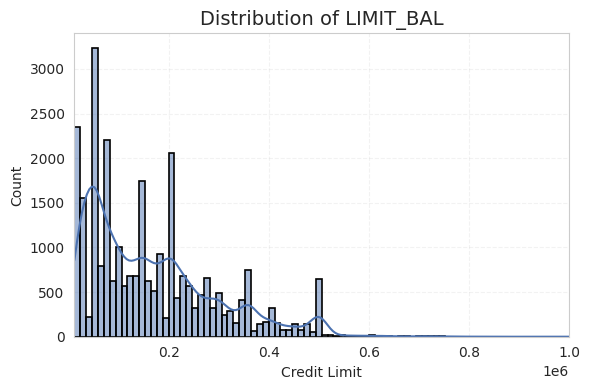

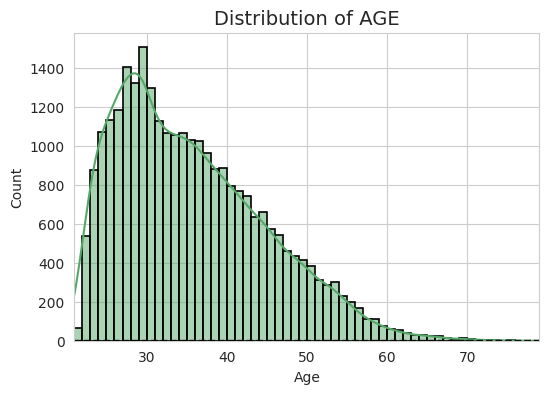

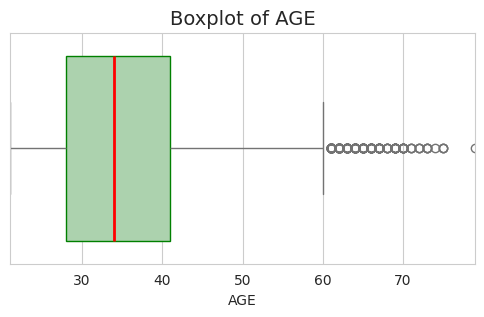

/tmp/ipython-input-3290148124.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df['SEX'],


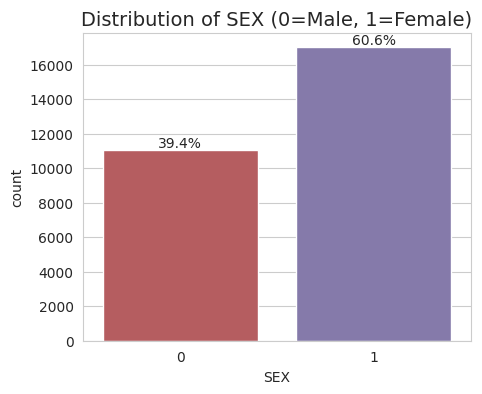

/tmp/ipython-input-3290148124.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df['EDUCATION'],


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

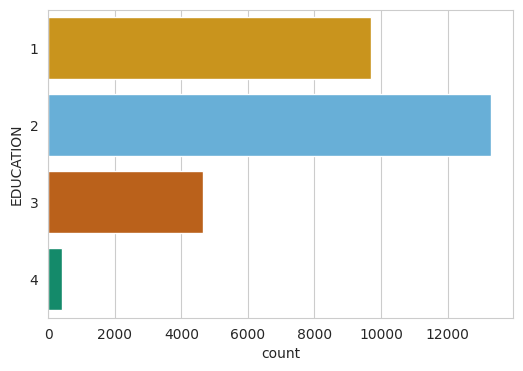

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style("whitegrid")  # 깔끔한 스타일

df = pd.read_csv('/content/sample_data/final_credit_clean.csv')

# ===== 1. LIMIT_BAL =====
plt.figure(figsize=(6,4))

# --- Histogram (막대 색만 유지) ---
sns.histplot(
    df['LIMIT_BAL'],
    kde=True,            # ★ 여기! KDE 제거해야 색 분리 가능
    color='#4C72B0',      # 막대 색 (원래 그대로)
    edgecolor='black',
    linewidth=1.2
)
'''
# --- KDE 라인만 별도 색으로 ---
sns.kdeplot(
    df['LIMIT_BAL'],
    color='#000000',      # ★ 선 색: 원하는 걸로 아무거나 가능
    linewidth=2.2
)'''

plt.title('Distribution of LIMIT_BAL', fontsize=14)
plt.xlabel('Credit Limit')

# x축 공백 제거
plt.xlim(df['LIMIT_BAL'].min(), df['LIMIT_BAL'].max())

# 그리드 세련되게 변경
plt.grid(True, linestyle='--', alpha=0.25)

plt.tight_layout()
plt.show()




# ===== AGE =====
plt.figure(figsize=(6,4))

#  정수형 bin으로 설정 → 빈 부분 제거!
bins = range(df['AGE'].min(), df['AGE'].max() + 1)

sns.histplot(df['AGE'], bins=bins, kde=True,
             color='#55A868', edgecolor='black', linewidth=1.2)

sns.kdeplot(df['AGE'], linestyle='--', color='black', linewidth=1.3)
plt.title('Distribution of AGE', fontsize=14)
plt.xlabel('Age')

# x축 공백 제거
plt.xlim(df['AGE'].min(), df['AGE'].max())
plt.show()


plt.figure(figsize=(6,3))
sns.boxplot(x=df['AGE'],
            color='#A6D8A8',
            boxprops=dict(edgecolor='green'),
            medianprops=dict(color='red', linewidth=2))
plt.title('Boxplot of AGE', fontsize=14)

# x축 공백 제거
plt.xlim(df['AGE'].min(), df['AGE'].max())
plt.show()



# ===== 3. SEX =====
plt.figure(figsize=(5,4))
ax = sns.countplot(x=df['SEX'],
                   palette=['#C44E5280', '#8172B280'])  # 투명도(알파) 적용
plt.title('Distribution of SEX (0=Male, 1=Female)', fontsize=14)
plt.xlabel('SEX')

total = len(df)
for p in ax.patches:
    percentage = f"{(p.get_height() / total) * 100:.1f}%"
    ax.annotate(percentage,
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom')
plt.show()


# ===== 4. EDUCATION =====
plt.figure(figsize=(6,4))
ax = sns.countplot(y=df['EDUCATION'],
                   palette=['#E69F00', '#56B4E9', '#D55E00', '#009E73'])
plt

목표 변수 분포 - 연체/비연체 비율 확인

=== 📌 연체 여부 분포 (Count) ===
default payment next month
0    21738
1     6318
Name: count, dtype: int64

=== 📌 연체 여부 분포 (Percentage) ===
default payment next month
0    77.480753
1    22.519247
Name: proportion, dtype: float64


/tmp/ipython-input-983879818.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=target, data=df,


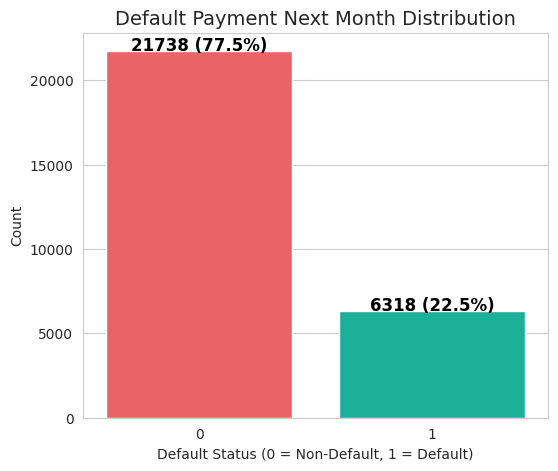

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ 데이터 불러오기
df = pd.read_csv('/content/sample_data/final_credit_clean.csv')

# 2️⃣ 타깃 변수명 지정
target = 'default payment next month'   # 0=비연체, 1=연체

# 3️⃣ 빈도와 비율 출력
print("=== 📌 연체 여부 분포 (Count) ===")
print(df[target].value_counts())

print("\n=== 📌 연체 여부 분포 (Percentage) ===")
print(df[target].value_counts(normalize=True) * 100)

# 4️⃣ 시각화
plt.figure(figsize=(6,5))
ax = sns.countplot(x=target, data=df,
                   palette=['#FF4E50', '#03C9A9'])  # 🔥 빨강 vs 청록 네온

plt.title('Default Payment Next Month Distribution', fontsize=14)
plt.xlabel('Default Status (0 = Non-Default, 1 = Default)')
plt.ylabel('Count')

# 🔹 개수 & 퍼센트 동시 표시
counts = df[target].value_counts()
total = len(df)

for i, v in enumerate(counts):
    percent = f"{(v/total)*100:.1f}%"
    ax.text(i, v + 50, f"{v} ({percent})",
            ha='center', fontsize=12, fontweight='bold', color='black')

plt.show()



범주형 변수와 연체율 관계 - 범주별(성별, 학력, 결혼 상대)로 연체율이 어떻게 다른지 비교

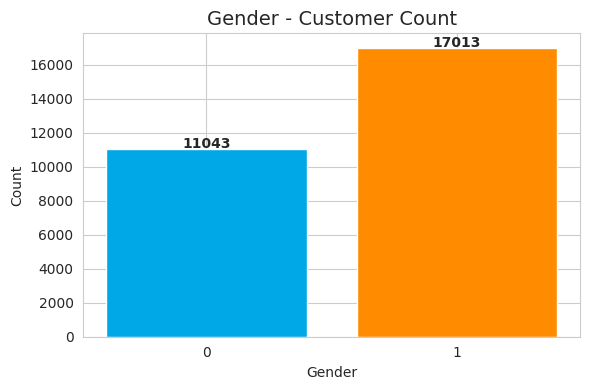

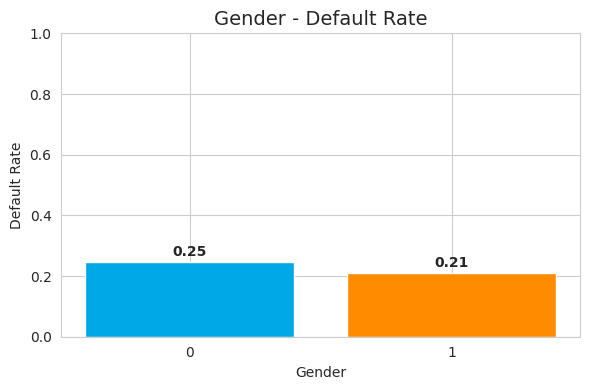

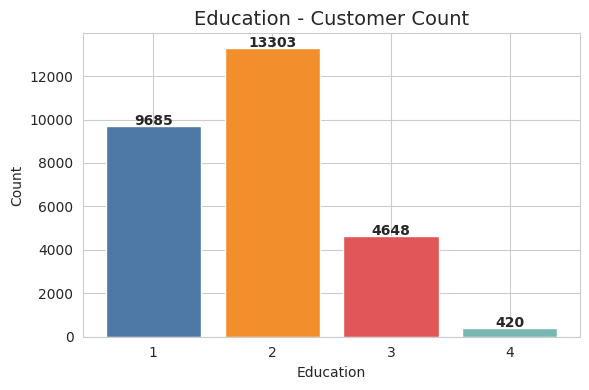

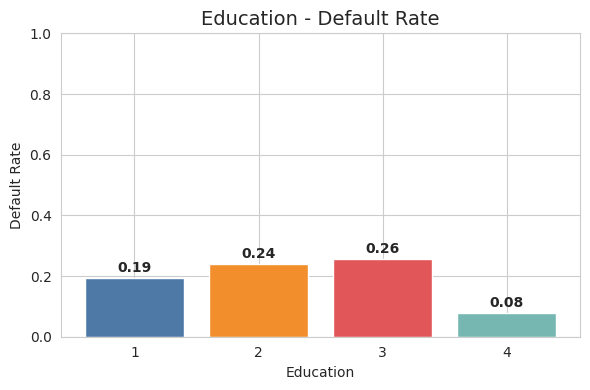

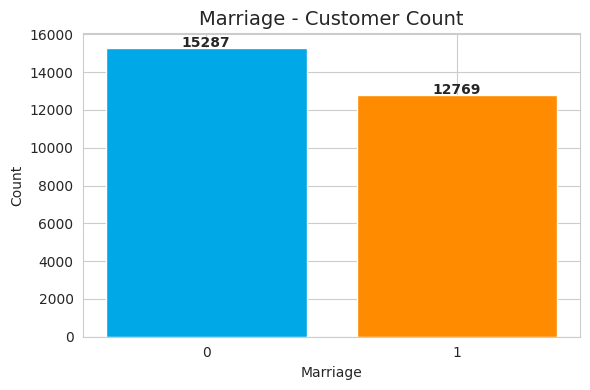

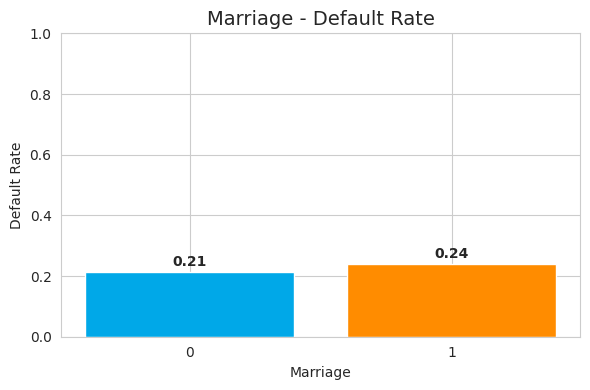

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기
df = pd.read_csv('/content/sample_data/final_credit_clean.csv')

# 컬럼 영어로 변경
df_plot = df.rename(columns={
    'SEX': 'Gender',
    'EDUCATION': 'Education',
    'MARRIAGE': 'Marriage',
    'default payment next month': 'DefaultNextMonth'
})

# 범주형 변수 리스트
categorical_cols = ['Gender', 'Education', 'Marriage']

# 색상 매핑 변경
# Gender / Marriage: 0=파랑, 1=주황
# Education: 1~4는 개별 색
color_map = {
    'Gender':     {0:'#00A8E8', 1:'#FF8C00'},
    'Marriage':   {0:'#00A8E8', 1:'#FF8C00'},
    'Education':  {1:'#4E79A7', 2:'#F28E2B', 3:'#E15759', 4:'#76B7B2'}  # 4가지 컬러
}

def plot_default_rate_one(df, col_name):
    count_data = df[col_name].value_counts().sort_index()
    default_rate = df.groupby(col_name)['DefaultNextMonth'].mean().sort_index()

    cmap = color_map[col_name]

    # Count Plot
    plt.figure(figsize=(6,4))
    for x, y in zip(count_data.index, count_data.values):
        color = cmap.get(x, '#A9A9A9')
        plt.bar(str(x), y, color=color)
        plt.text(str(x), y+50, int(y), ha='center', fontweight='bold')
    plt.title(f"{col_name} - Customer Count", fontsize=14)
    plt.xlabel(col_name)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Default Rate Plot
    plt.figure(figsize=(6,4))
    for x, y in zip(default_rate.index, default_rate.values):
        color = cmap.get(x, '#A9A9A9')
        plt.bar(str(x), y, color=color)
        plt.text(str(x), y+0.02, f"{y:.2f}", ha='center', fontweight='bold')
    plt.title(f"{col_name} - Default Rate", fontsize=14)
    plt.xlabel(col_name)
    plt.ylabel("Default Rate")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


# 실행
for col in categorical_cols:
    plot_default_rate_one(df_plot, col)




수치형 변수와 연체율 관계 - 신용한도, 나이 등에 따른 연체 그룹 분포 비교

-기본 수치형 변수
1. 수치형 변수별 연체 그룹 평균 비교 표

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ 데이터 불러오기
df = pd.read_csv('/content/sample_data/final_credit_clean.csv')

# 2️⃣ 분석할 수치형 변수
numeric_vars = ['LIMIT_BAL', 'AGE']   # 필요하면 더 추가해도 됨
target = 'default payment next month'

# 3️⃣ 수치형 변수별 연체 여부에 따른 평균 비교
print("=== 📌 연체 여부에 따른 수치형 변수 평균 비교 ===")
display(df.groupby(target)[numeric_vars].mean())


=== 📌 연체 여부에 따른 수치형 변수 평균 비교 ===


,LIMIT_BAL,AGE
default payment next month,,
0,175296.807434,35.389732
1,126984.438113,35.651472


2. 박스플롯(수치형 변수 vs 연체여부)

/tmp/ipython-input-2890355352.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette=palette)


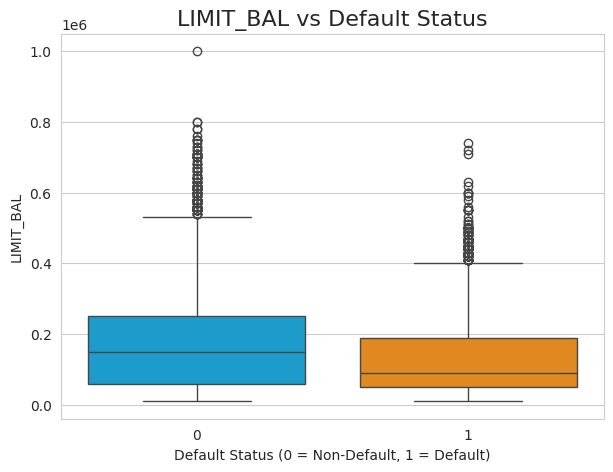

/tmp/ipython-input-2890355352.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette=palette)


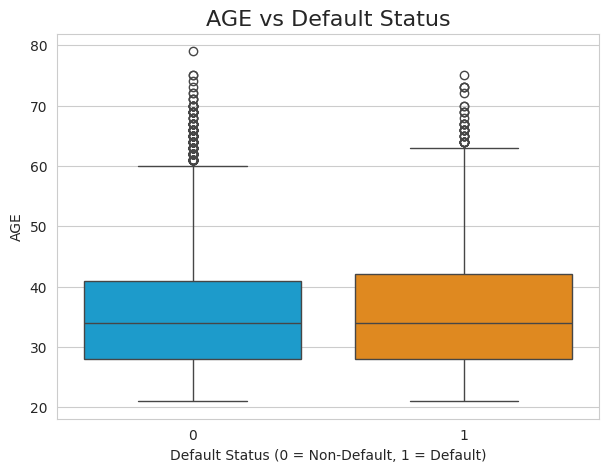

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 불러오기
df = pd.read_csv('/content/sample_data/final_credit_clean.csv')

target = 'default payment next month'

# 🔹 타깃 변수 타입 확인 및 변환
df[target] = df[target].astype(int)

numeric_vars = ['LIMIT_BAL', 'AGE']

# 🔹 0=파랑, 1=주황 팔레트
palette = {'0':'#00A8E8', '1':'#FF8C00'} # 딕셔너리 키를 정수에서 문자열로 변경

# 그래프
for col in numeric_vars:
    plt.figure(figsize=(7,5))
    sns.boxplot(x=target, y=col, data=df, palette=palette)
    plt.title(f'{col} vs Default Status', fontsize=16)
    plt.xlabel('Default Status (0 = Non-Default, 1 = Default)')
    plt.ylabel(col)
    plt.show()

3. 히스토그램 분포 비교(KDE 포함)

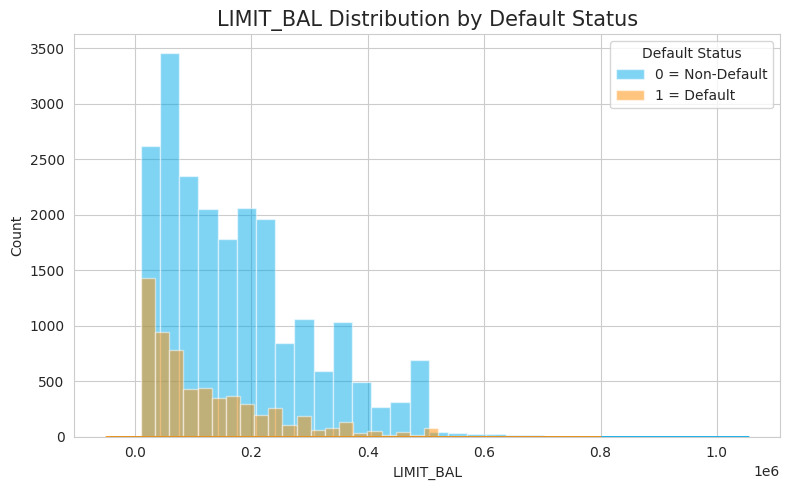

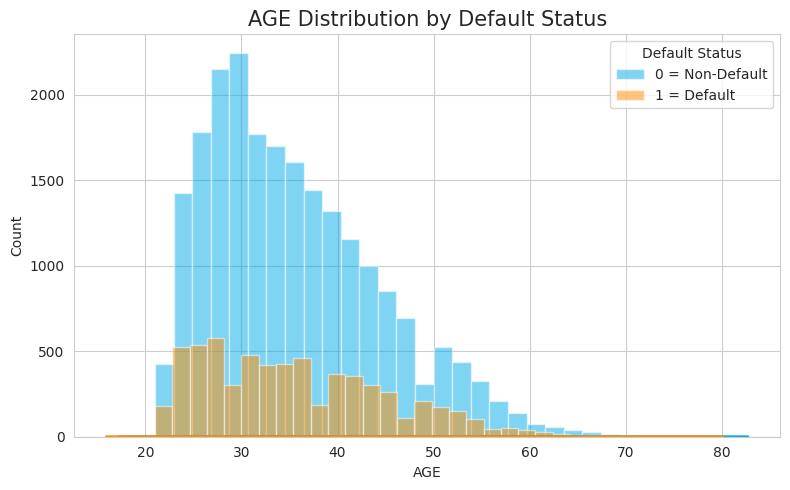

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ 데이터 불러오기
df = pd.read_csv('/content/sample_data/final_credit_clean.csv')

numeric_vars = ['LIMIT_BAL', 'AGE']
target = 'default payment next month'

# 2️⃣ 색상 지정 (일관성 유지)
color_0 = '#00A8E8'   # Non-Default (0)
color_1 = '#FF8C00'   # Default (1)

for col in numeric_vars:
    plt.figure(figsize=(8,5))

    # 3️⃣ 타깃별 데이터 나누기
    x0 = df[df[target] == 0][col]
    x1 = df[df[target] == 1][col]

    # 4️⃣ 히스토그램 (matplotlib로 직접 그리기 → 빈 기둥 없음)
    bins = 30  # 필요하면 조절 가능

    plt.hist(
        x0, bins=bins, alpha=0.5,
        color=color_0, label='0 = Non-Default',
        density=False
    )
    plt.hist(
        x1, bins=bins, alpha=0.5,
        color=color_1, label='1 = Default',
        density=False
    )

    # 5️⃣ KDE 라인만 seaborn으로 얹기 (부드러운 곡선)
    sns.kdeplot(x=x0, color=color_0, linewidth=2)
    sns.kdeplot(x=x1, color=color_1, linewidth=2)

    # 6️⃣ 제목 / 라벨 / 범례
    plt.title(f'{col} Distribution by Default Status', fontsize=15)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Default Status')

    plt.tight_layout()
    plt.show()


4. 수치형 변수별 연체율 계산(고급 분석)

/tmp/ipython-input-2863279880.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate = df.groupby(f'{col}_bin')[target].mean() * 100



📌 LIMIT_BAL 구간별 연체율 (%)
LIMIT_BAL_bin
(9999.999, 50000.0]      32.221318
(50000.0, 140000.0]      24.852234
(140000.0, 230000.0]     17.667027
(230000.0, 1000000.0]    14.279526
Name: default payment next month, dtype: float64


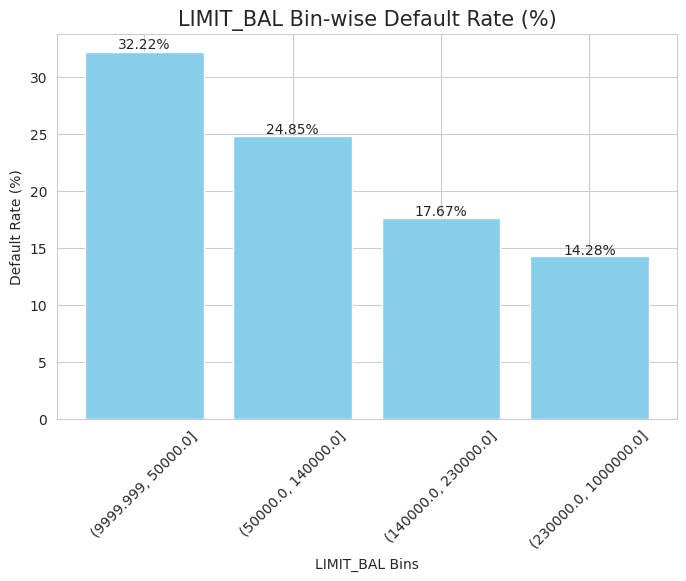

/tmp/ipython-input-2863279880.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate = df.groupby(f'{col}_bin')[target].mean() * 100



📌 AGE 구간별 연체율 (%)
AGE_bin
(20.999, 28.0]    23.881579
(28.0, 34.0]      19.823108
(34.0, 41.0]      22.016040
(41.0, 79.0]      24.247204
Name: default payment next month, dtype: float64


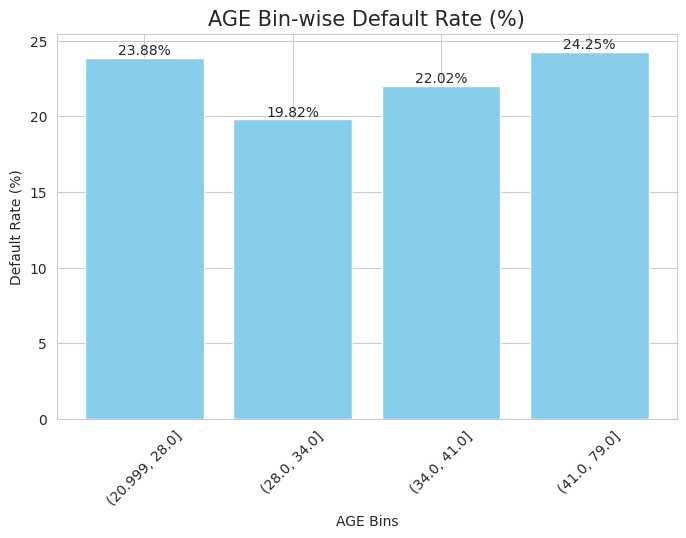

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ 데이터 불러오기
df = pd.read_csv('/content/sample_data/final_credit_clean.csv')

# 2️⃣ 분석할 변수들
numeric_vars = ['LIMIT_BAL', 'AGE']
target = 'default payment next month'

# 3️⃣ 수치형 변수별 연체율 계산 + 시각화
for col in numeric_vars:

    # 🔹 분위수 기반 구간 나누기 (4구간)
    df[f'{col}_bin'] = pd.qcut(df[col], q=4, duplicates='drop')

    # 🔹 구간별 연체율 계산 (%)
    default_rate = df.groupby(f'{col}_bin')[target].mean() * 100

    print("\n==============================")
    print(f"📌 {col} 구간별 연체율 (%)")
    print("==============================")
    print(default_rate)

    # 🔹 시각화 + 퍼센트 표시
    plt.figure(figsize=(8,5), dpi=100)
    bars = plt.bar(default_rate.index.astype(str), default_rate.values, color='skyblue')

    plt.title(f'{col} Bin-wise Default Rate (%)', fontsize=15)
    plt.ylabel('Default Rate (%)')
    plt.xlabel(f'{col} Bins')
    plt.xticks(rotation=45)

    # ✨ 텍스트 위치를 height * 1.01 정도로 (막대 바로 위)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height * 1.01,
                 f'{height:.2f}%', ha='center', fontsize=10)

    plt.show()


BILL_AMT1~6(청구금액 6개) 히스토그램 + KDE (연체 여부 비교)

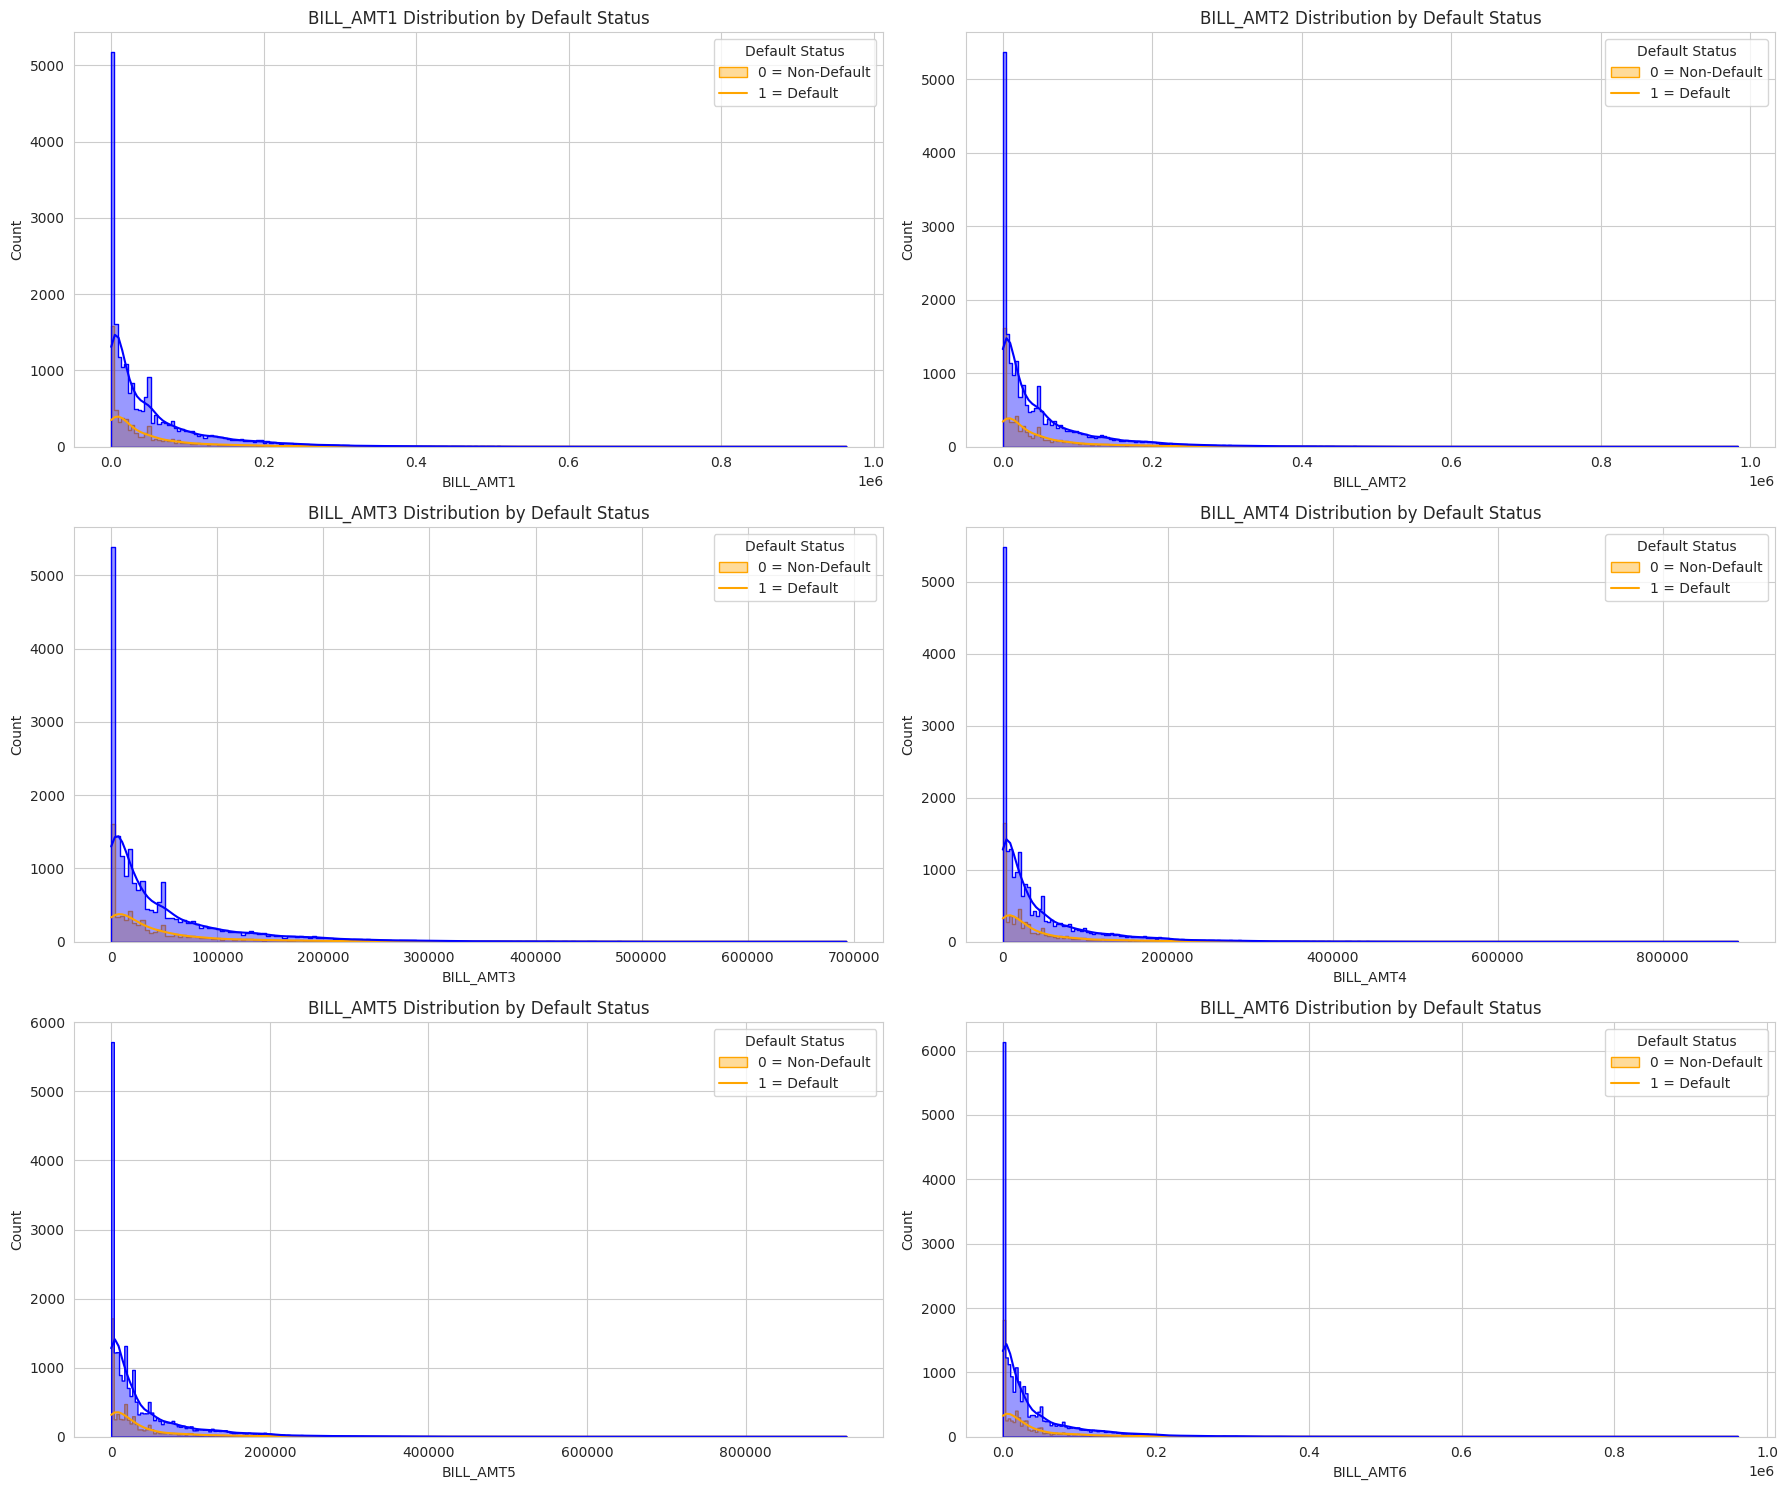

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ 데이터 불러오기
df = pd.read_csv('/content/sample_data/final_credit_clean.csv')

# 2️⃣ BILL_AMT 변수 목록
bill_vars = [f'BILL_AMT{i}' for i in range(1, 7)]
target = 'default payment next month'

# 3️⃣ 3×2 subplot 구성
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
axes = axes.flatten()

# 4️⃣ BILL_AMT1~6 분포 비교 그래프 생성
for i, col in enumerate(bill_vars):
    ax = axes[i]

    sns.histplot(
        data=df, x=col, hue=target,
        kde=True,
        palette={0:'blue', 1:'orange'},
        alpha=0.4,
        element='step',
        ax=ax
    )

    ax.set_title(f'{col} Distribution by Default Status', fontsize=12)
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

    # 범례 이름 통일
    ax.legend(title="Default Status", labels=["0 = Non-Default", "1 = Default"])

# 간격 정리
plt.tight_layout()


BILL_AMT1~6(청구금액 6개) 구간별 연체율(bin-wise default rate)→ 청구금액이 어느 정도일 때 연체 위험이 높은지 분석




/tmp/ipython-input-2195223940.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df.groupby(f'{col}_bin')[target].mean() * 100
/tmp/ipython-input-2195223940.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(rate.index.astype(str), rotation=45)
/tmp/ipython-input-2195223940.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df.groupby(f'{col}_bin')[target].mean() * 100
/tmp/ipython-input-2195223940.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e.

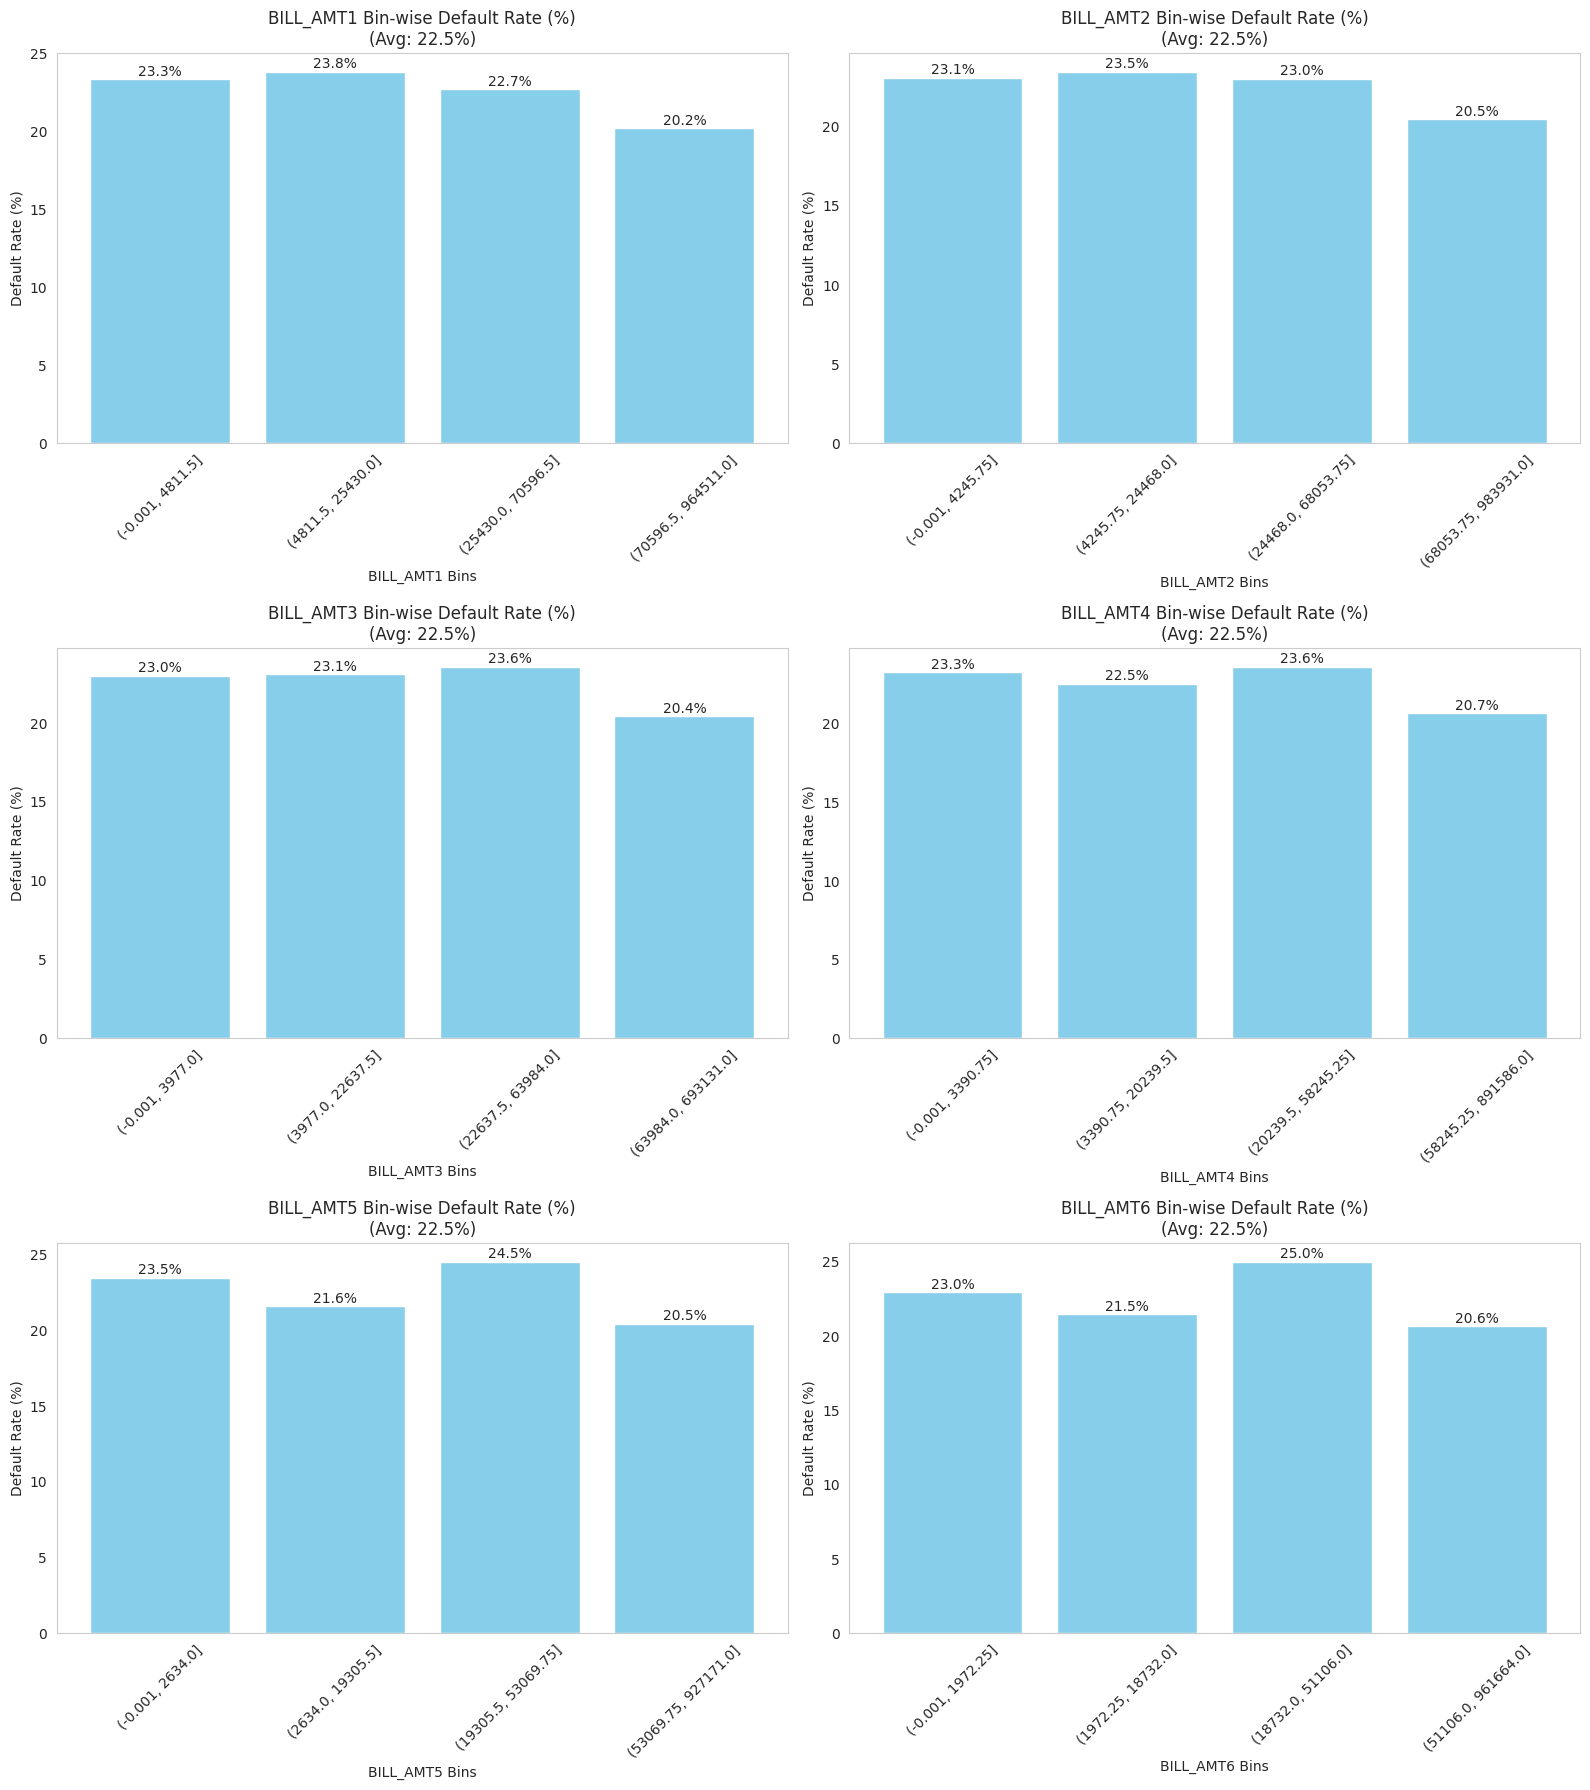

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ 데이터 불러오기
df = pd.read_csv('/content/sample_data/final_credit_clean.csv')

# 2️⃣ BILL_AMT 변수 목록
bill_vars = [f'BILL_AMT{i}' for i in range(1, 7)]
target = 'default payment next month'

# 3️⃣ 시각화 설정
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

# 4️⃣ 변수별 bin-wise default rate 계산 + 시각화
for i, col in enumerate(bill_vars):
    ax = axes[i]

    # 분위수 기반 구간 나누기 (4분위)
    df[f'{col}_bin'] = pd.qcut(df[col], q=4, duplicates='drop')

    # 구간별 연체율 (%)
    rate = df.groupby(f'{col}_bin')[target].mean() * 100
    mean_rate = rate.mean()   # 평균 연체율 → 제목에 반영

    bars = ax.bar(rate.index.astype(str), rate.values, color='skyblue')

    # 제목에 평균 퍼센트 포함
    ax.set_title(f'{col} Bin-wise Default Rate (%)\n(Avg: {mean_rate:.1f}%)', fontsize=12)

    ax.set_ylabel('Default Rate (%)')
    ax.set_xlabel(f'{col} Bins')
    ax.set_xticklabels(rate.index.astype(str), rotation=45)

    # 막대 위에 개별 퍼센트 표시
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height * 1.01,
                f'{height:.1f}%', ha='center', fontsize=10)

    ax.grid(False)  # 배경선 제거

plt.tight_layout()



PAY_AMT1~6(지불금액 6개) 히스토그램 + KDE (연체 여부 비교)

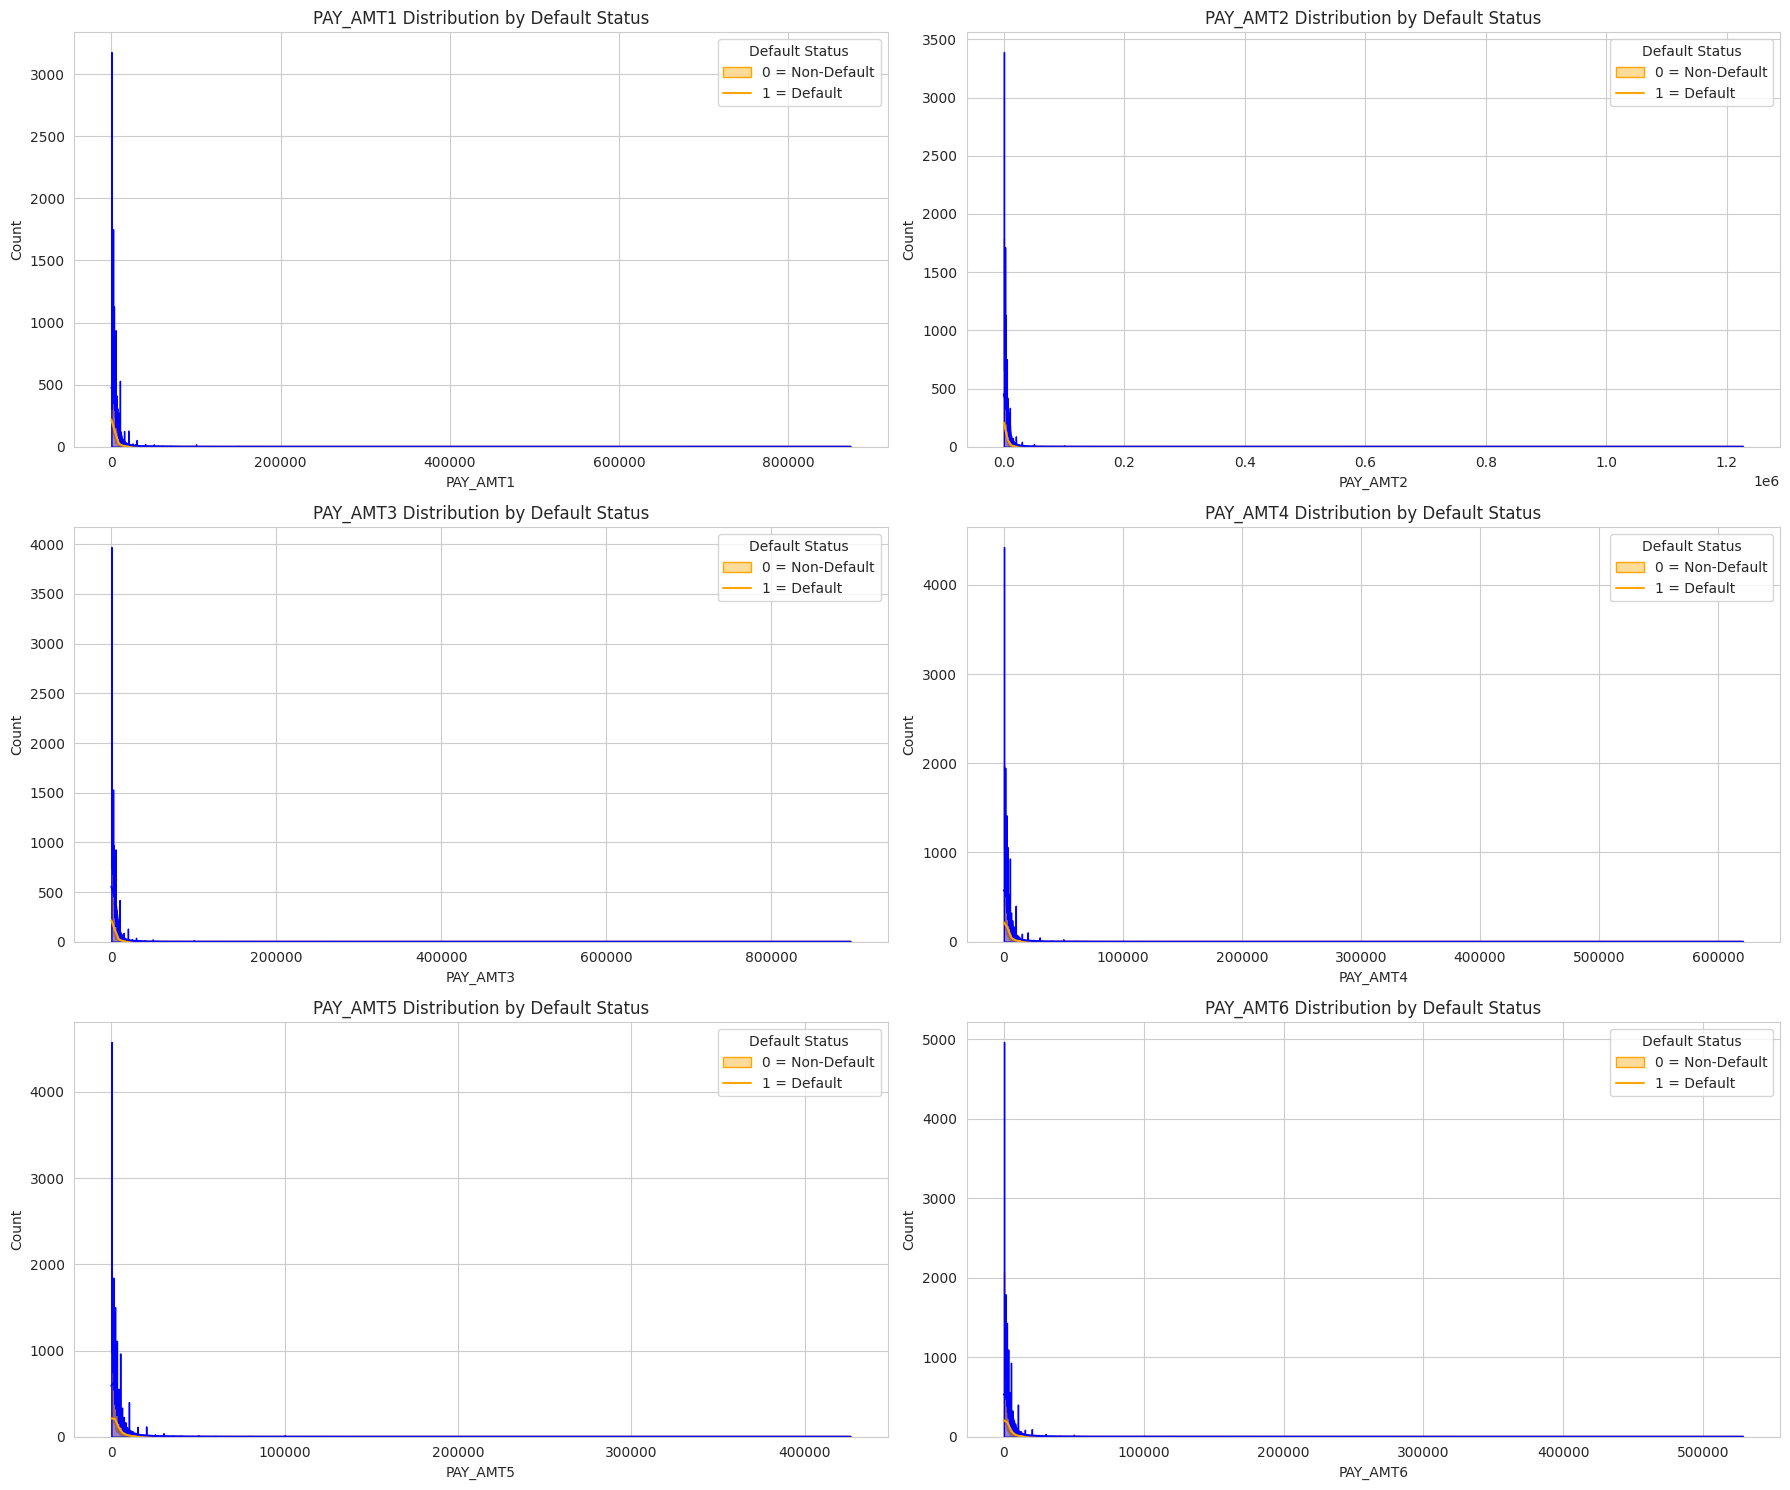

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ 데이터 불러오기
df = pd.read_csv('/content/sample_data/final_credit_clean.csv')

# 2️⃣ PAY_AMT 변수 목록
pay_vars = [f'PAY_AMT{i}' for i in range(1, 7)]
target = 'default payment next month'

# 3️⃣ 3×2 subplot 구성
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
axes = axes.flatten()

# 4️⃣ PAY_AMT1~6 그래프 생성
for i, col in enumerate(pay_vars):
    ax = axes[i]

    sns.histplot(
        data=df,
        x=col,
        hue=target,
        kde=True,
        palette={0: 'blue', 1: 'orange'},
        alpha=0.4,
        element='step',
        ax=ax
    )

    # 제목 및 축 설정
    ax.set_title(f'{col} Distribution by Default Status', fontsize=12)
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

    # 범례 유지
    ax.legend(title="Default Status", labels=["0 = Non-Default", "1 = Default"])

# 5️⃣ 레이아웃 정리
plt.tight_layout()


2. PAY_AMT1~6(지불금액 6개 구간별 연체율(bin-wise default rate)

/tmp/ipython-input-720866713.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df.groupby(f'{col}_bin')[target].mean() * 100
/tmp/ipython-input-720866713.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(rate.index.astype(str), rotation=45)
/tmp/ipython-input-720866713.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df.groupby(f'{col}_bin')[target].mean() * 100
/tmp/ipython-input-720866713.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. aft

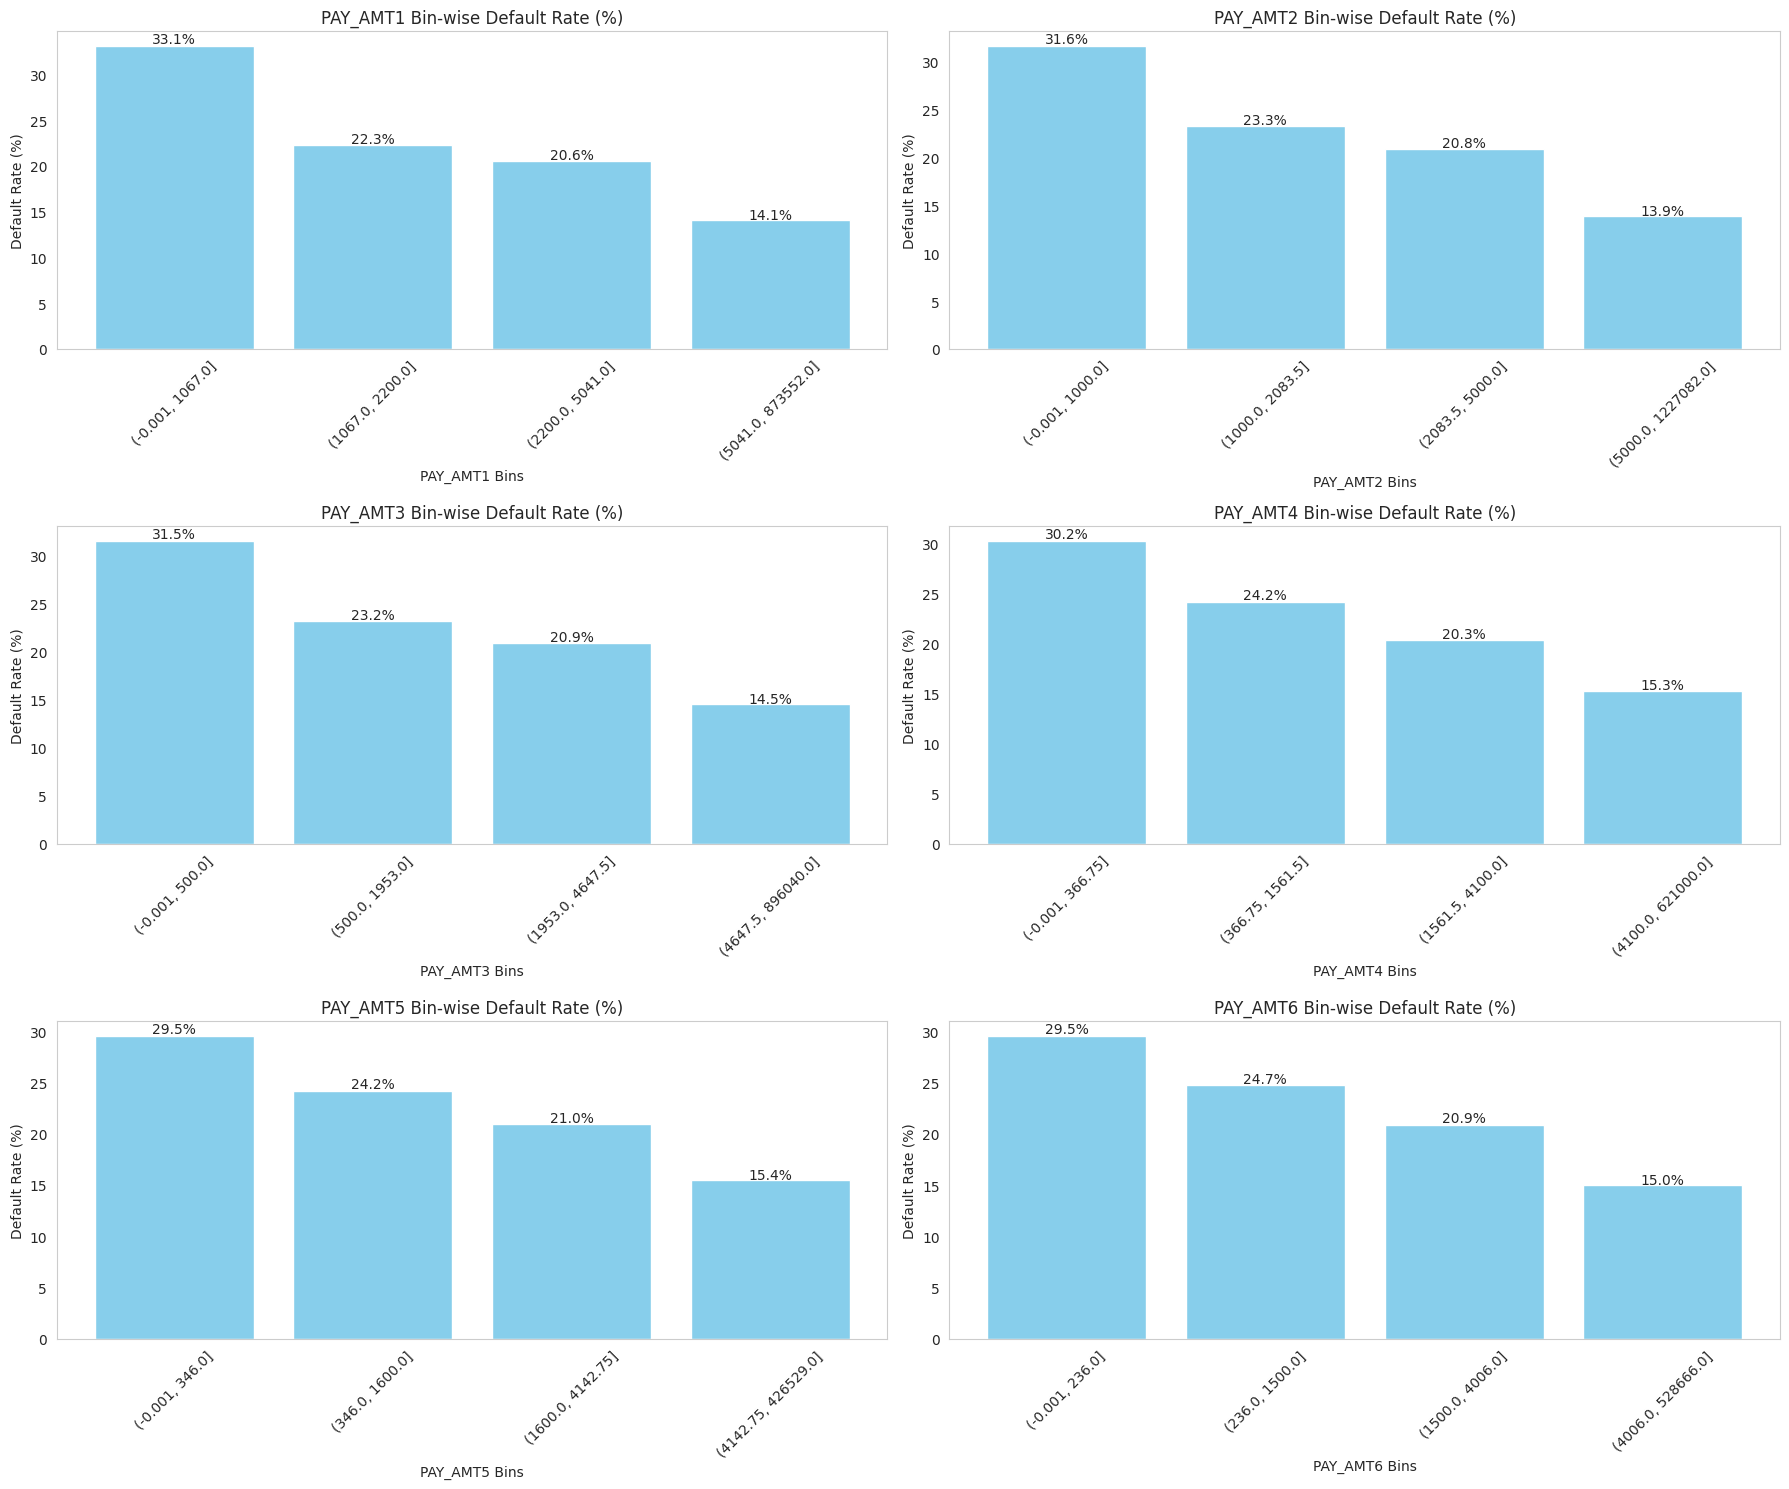

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ 데이터 불러오기
df = pd.read_csv('/content/sample_data/final_credit_clean.csv')

# 2️⃣ PAY_AMT 변수 목록
pay_vars = [f'PAY_AMT{i}' for i in range(1, 7)]
target = 'default payment next month'

# 3️⃣ subplot 설정 (3행 2열)
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
axes = axes.flatten()

# 4️⃣ 변수별 bin-wise default rate 계산 + 시각화
for i, col in enumerate(pay_vars):

    ax = axes[i]

    # 🔹 분위수 기반 구간 나누기 (4구간)
    df[f'{col}_bin'] = pd.qcut(df[col], q=4, duplicates='drop')

    # 🔹 구간별 연체율(%)
    rate = df.groupby(f'{col}_bin')[target].mean() * 100

    bars = ax.bar(rate.index.astype(str), rate.values, color='skyblue')

    # 제목
    ax.set_title(f'{col} Bin-wise Default Rate (%)', fontsize=12)

    # 축 labels
    ax.set_ylabel('Default Rate (%)')
    ax.set_xlabel(f'{col} Bins')

    # x축 글씨 회전
    ax.set_xticklabels(rate.index.astype(str), rotation=45)

    # 💬 막대 위에 퍼센트 표시
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height * 1.01,
                f'{height:.1f}%', ha='center', fontsize=10)

    # 🚫 격자선 제거
    ax.grid(False)

# 5️⃣ 여백 정리
plt.tight_layout()

수치형 변수들 간 상관관계 분석 - 변수들 간의 선형 관계 파악

1. 수치형 변수 자동 추출 + 상관계수 계산 + Heatmap

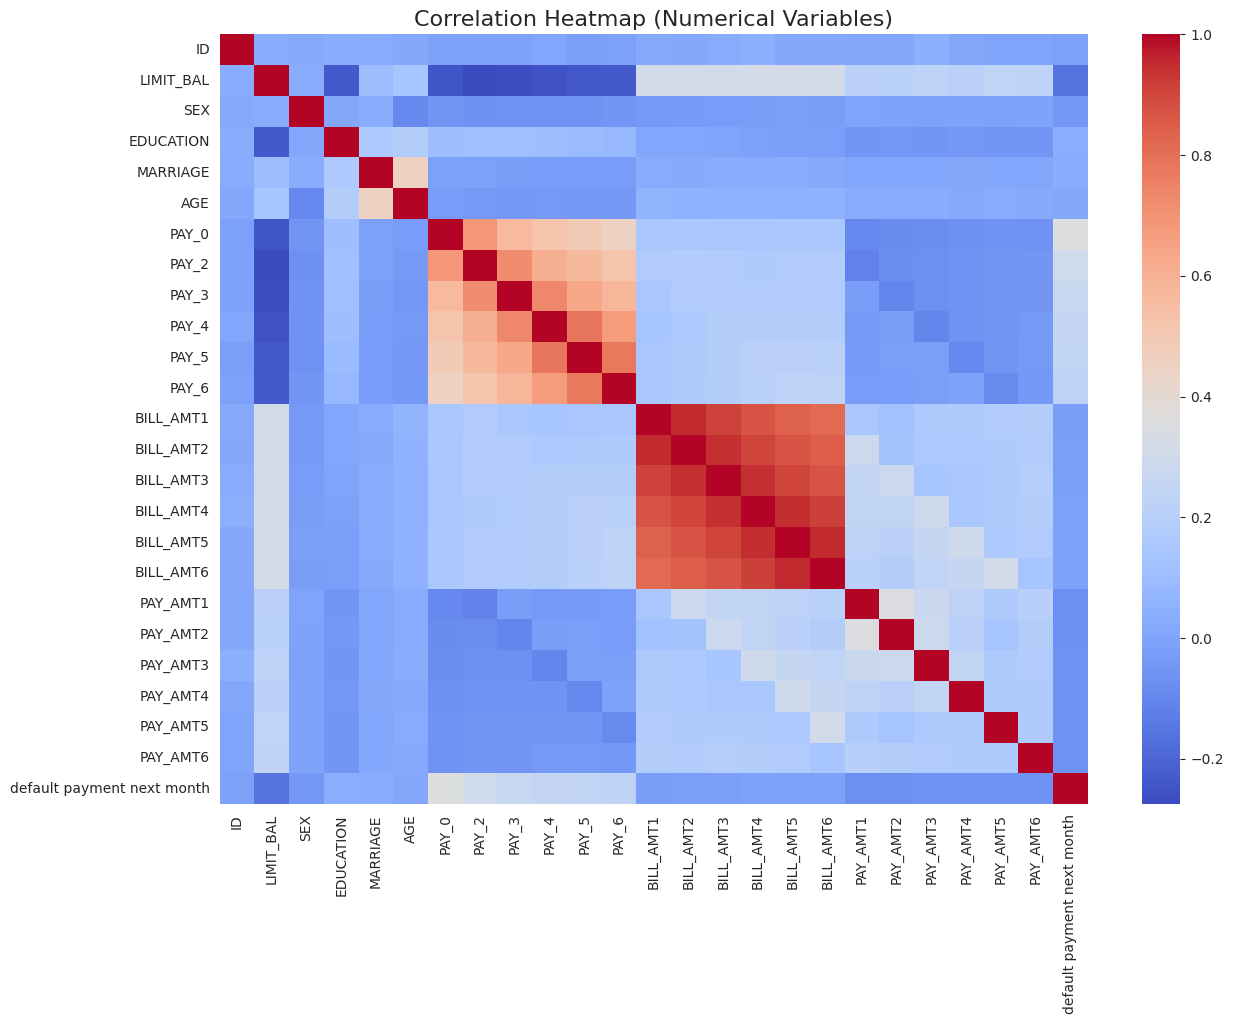

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ 데이터 불러오기
df = pd.read_csv('/content/sample_data/final_credit_clean.csv')

# 2️⃣ 수치형 변수 자동 추출
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# 3️⃣ 상관계수(correlation) 계산
corr = numeric_df.corr()

# 4️⃣ Heatmap 시각화
plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap (Numerical Variables)', fontsize=16)
plt.show()


2. 다음달 연체 여부(target)와의 상관관계만 따로 보기

In [22]:
target = 'default payment next month'

target_corr = corr[target].sort_values(ascending=False)

print("📌 다음달 연체 여부와 관련 높은 수치형 변수 상관계수")
print(target_corr)


📌 다음달 연체 여부와 관련 높은 수치형 변수 상관계수
default payment next month    1.000000
PAY_0                         0.360054
PAY_2                         0.300238
PAY_3                         0.267471
PAY_4                         0.252061
PAY_5                         0.241745
PAY_6                         0.224245
EDUCATION                     0.036543
MARRIAGE                      0.029047
AGE                           0.011829
BILL_AMT6                    -0.009022
BILL_AMT5                    -0.010004
ID                           -0.013563
BILL_AMT4                    -0.014054
BILL_AMT3                    -0.017401
BILL_AMT2                    -0.019257
BILL_AMT1                    -0.025244
SEX                          -0.043176
PAY_AMT6                     -0.057762
PAY_AMT4                     -0.058120
PAY_AMT3                     -0.058132
PAY_AMT5                     -0.060892
PAY_AMT2                     -0.066511
PAY_AMT1                     -0.074987
LIMIT_BAL                    -0.1